QUANTITATIVE TRAIT LOCI are regions of the genome associated with traits such as height, BMI etc.. If the trait is an expression of a gene then we are faced with an eQTL. 

# Imports and Consts

In [58]:
import pandas as pd
import numpy as np
import statsmodels.api
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
DATASET_PAH = "./Dataset/"

# Load and preprocess data

In [3]:
rnaSeqData = pd.read_csv(DATASET_PAH + "GD660.GeneQuantRPKM.txt", delimiter="\t")

In [4]:
rnaSeqData

,TargetID,Gene_Symbol,Chr,Coord,HG00096.1.M_111124_6,HG00097.7.M_120219_2,HG00099.1.M_120209_6,HG00099.5.M_120131_3,HG00100.2.M_111215_8,HG00101.1.M_111124_4,...,NA20810.2.M_111215_7,NA20811.1.M_111124_5,NA20812.2.M_111216_6,NA20813.5.M_120131_1,NA20814.2.M_111215_6,NA20815.5.M_120131_5,NA20816.3.M_120202_7,NA20819.3.M_120202_2,NA20826.1.M_111124_1,NA20828.2.M_111216_8
0,ENSG00000225538.1,ENSG00000225538.1,11,55850277,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.03876,0.00000
1,ENSG00000237851.1,ENSG00000237851.1,6,143109260,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,ENSG00000243765.1,ENSG00000243765.1,15,58442766,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,ENSG00000257527.1,ENSG00000257527.1,16,18505708,0.70561,0.66697,0.64004,0.26195,0.34695,1.49208,...,0.87085,0.94950,0.95837,0.51002,0.29422,0.22960,0.58671,0.27674,0.53630,0.17139
4,ENSG00000212855.5,ENSG00000212855.5,Y,9578193,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53929,ENSG00000172297.6,ENSG00000172297.6,Y,27600708,0.13907,0.10224,0.00000,0.08924,0.19945,0.00000,...,0.07151,0.00000,0.18889,0.08700,0.15464,0.13199,0.19273,0.15151,0.11010,0.15483
53930,ENSG00000259738.1,ENSG00000259738.1,15,59157205,0.00000,0.13191,0.00000,0.00000,0.15789,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
53931,ENSG00000212040.1,ENSG00000212040.1,14,101498324,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
53932,ENSG00000125266.5,ENSG00000125266.5,13,107187462,0.12923,0.07601,0.32377,0.25588,0.05295,0.16194,...,0.34558,0.12560,0.22624,0.08303,0.15089,0.09111,0.13432,0.19148,0.05730,0.12557


In [5]:
f = open(DATASET_PAH + "ALL.wgs.mergedSV.v8.20130502.svs.genotypes.vcf", "r")
columns = None
for l in f:
    if "#CHROM" in l:
        columns = l.split("\t")
        break

In [7]:
columns[0] = columns[0].replace("#", "")

In [8]:
columns[len(columns) - 1] = columns[len(columns) - 1].replace("\n", "")

In [9]:
vcfSourceFile = pd.read_csv(
    DATASET_PAH + "ALL.wgs.mergedSV.v8.20130502.svs.genotypes.vcf",
    sep="\t",
    comment="#",
    names=columns,
    header=None,
)

/tmp/ipykernel_20700/2618528307.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  vcfSourceFile = pd.read_csv(


In [10]:
vcfSourceFile

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,HG00096,...,NA21128,NA21129,NA21130,NA21133,NA21135,NA21137,NA21141,NA21142,NA21143,NA21144
0,1,645710,ALU_umary_ALU_2,A,<INS:ME:ALU>,.,.,AC=35;AF=0.00698882;AFR_AF=0;AMR_AF=0.0072;AN=...,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
1,1,668630,DUP_delly_DUP20532,G,<CN2>,.,PASS,AC=64;AF=0.0127795;AFR_AF=0.0015;AMR_AF=0;AN=5...,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
2,1,713044,DUP_gs_CNV_1_713044_755966,C,"<CN0>,<CN2>",.,PASS,"AC=3,206;AF=0.00059904,0.0411342;AFR_AF=0,0.03...",GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,2|0,0|0,2|0,0|2
3,1,738570,UW_VH_21763,G,<CN0>,100,PASS,AC=1;AF=0.00019968;AFR_AF=0;AMR_AF=0;AN=5008;C...,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
4,1,766600,UW_VH_5595,G,<CN0>,100,PASS,AC=188;AF=0.0375399;AFR_AF=0.0151;AMR_AF=0.062...,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68813,X,155064470,DUP_gs.X_CNV_X_155064470_155081667,C,<CN2>,.,PASS,AC=1;AF=0.00019968;AFR_AF=0;AMR_AF=0;AN=5008;C...,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
68814,X,155090084,UW_VH_7995,A,<CN0>,100,PASS,AC=102;AF=0.0385383;AFR_AF=0.1369;AMR_AF=0.015...,GT,.,...,.,.,.,.,.,0|0,0|0,0|0,0|0,0|0
68815,X,155120139,L1_umary_LINE1_3151,T,<INS:ME:LINE1>,.,PASS,AC=1;AF=0.00019968;AFR_AF=0;AMR_AF=0;AN=5008;C...,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
68816,X,155122541,DEL_pindel_54975,GAGTAACTGGGATGACAGGCGTGTGCCACCACGCCTGGCTAATTTT...,G,.,PASS,AC=1;AF=0.00019968;AFR_AF=0.0008;AMR_AF=0;AN=5...,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0


In [11]:
vcfSourceFile.columns

Index(['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT',
       'HG00096',
       ...
       'NA21128', 'NA21129', 'NA21130', 'NA21133', 'NA21135', 'NA21137',
       'NA21141', 'NA21142', 'NA21143', 'NA21144'],
      dtype='object', length=2513)

In [12]:
vcfSourceFile["CHROM"] = vcfSourceFile["CHROM"].apply(lambda x: str(x))
# I pick only 1 chromosome to make sure the computation time is reasonable
vcfSourceFile = vcfSourceFile[vcfSourceFile["CHROM"] == "20"].copy()

In [13]:
vcfSourceFile

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,HG00096,...,NA21128,NA21129,NA21130,NA21133,NA21135,NA21137,NA21141,NA21142,NA21143,NA21144
63261,20,118471,DUP_delly_DUP55813,T,<CN2>,.,PASS,AC=4;AF=0.00079872;AFR_AF=0.0015;AMR_AF=0;AN=5...,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
63262,20,118498,DUP_gs_CNV_20_118498_242177,G,<CN2>,.,PASS,AC=1;AF=0.00019968;AFR_AF=0;AMR_AF=0;AN=5008;C...,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
63263,20,249590,BI_GS_DEL1_B5_P2733_211,C,<CN0>,100,PASS,AC=1;AF=0.00019968;AFR_AF=0;AMR_AF=0;AN=5008;C...,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
63264,20,283851,SVA_umary_SVA_770,T,<INS:ME:SVA>,.,.,AC=5;AF=0.0009984;AFR_AF=0;AMR_AF=0;AN=5008;CS...,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
63265,20,294022,BI_GS_DEL1_B4_P2733_46,C,<CN0>,100,PASS,AC=1;AF=0.00019968;AFR_AF=0.0008;AMR_AF=0;AN=5...,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64825,20,62891341,DUP_gs_CNV_20_62891341_62900705,G,<CN2>,.,PASS,AC=2;AF=0.00039936;AFR_AF=0.0015;AMR_AF=0;AN=5...,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
64826,20,62891722,DEL_pindel_51199,GAGACCGCAGCCTTCCCAGTAGTTATCTGACATTGACACATCACTG...,G,.,PASS,AC=1;AF=0.00019968;AFR_AF=0;AMR_AF=0;AN=5008;C...,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
64827,20,62904563,DUP_gs_CNV_20_62904563_62915351,C,<CN2>,.,PASS,AC=2;AF=0.00039936;AFR_AF=0.0015;AMR_AF=0;AN=5...,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
64828,20,62949512,DUP_gs_CNV_20_62949512_62957862,G,"<CN0>,<CN2>,<CN3>",.,PASS,"AC=707,262,19;AF=0.141174,0.0523163,0.00379393...",GT,0|0,...,0|0,0|1,0|1,0|1,0|1,1|0,0|1,0|0,0|0,1|0


In [14]:
newColumns = []
for i in range(len(rnaSeqData.columns)):
    newColumns.append(rnaSeqData.columns[i].split(".")[0])

In [15]:
rnaSeqData.columns = newColumns

In [16]:
rnaSeqData = rnaSeqData[rnaSeqData["Chr"] == "20"].copy()

In [17]:
commonColumns = rnaSeqData.columns.intersection(vcfSourceFile.columns)

In [18]:
commonColumns

Index(['HG00096', 'HG00097', 'HG00099', 'HG00100', 'HG00101', 'HG00102',
       'HG00103', 'HG00105', 'HG00106', 'HG00108',
       ...
       'NA20809', 'NA20810', 'NA20811', 'NA20812', 'NA20813', 'NA20814',
       'NA20815', 'NA20819', 'NA20826', 'NA20828'],
      dtype='object', length=445)

In [19]:
# Data preprocessing: ensuring proper types, mapping

vcfSourceFile["QUAL"] = vcfSourceFile["QUAL"].apply(lambda x: int(x) if x != "." else 0)

for column in commonColumns:
    vcfSourceFile[column] = vcfSourceFile[column].apply(
        # lambda x: sum([int(n) for n in x.split("|")]) if x != "." else 0
        lambda x: max([int(n) for n in x.split("|")]) if x != "." else 0
    )
for column in commonColumns:
    vcfSourceFile[column] = vcfSourceFile[column].apply(lambda x: int(x))

vcfSourceFile["ALT"] = vcfSourceFile["ALT"].apply(lambda x: x.split(","))


def processRow(row):
    for column in commonColumns:
        if row[column] != 0:
            row[column] = row["ALT"][row[column] - 1]
    return row


vcfSourceFile = vcfSourceFile.apply(lambda x: processRow(x), axis=1)

# 1. DONE: For each row count the number of occurences of each ALT, save it to a dictionary and turn to a dataframe, and merge based on id with vcf data
# 2. Find a way to merge rna and vcf dataframes, perhaps on closest position

In [20]:
def countUniqueALTs(row, d):
    uniqueALTs = row[commonColumns].unique()
    rowId = row.name
    d[rowId] = {}
    for alt in uniqueALTs:
        if alt == 0:
            continue
        d[rowId][alt] = 0
        for column in commonColumns:
            if row[column] == alt:
                d[rowId][alt] = d[rowId][alt] + 1
    for alt in d[rowId]:
        row[alt] = d[rowId][alt]
    return row


d = {}
vcfSourceFileCountedAlts = vcfSourceFile.apply(lambda x: countUniqueALTs(x, d), axis=1)

In [21]:
vcfSourceFileCountedAlts["POS"]

63261      118471
63262      118498
63263      249590
63264      283851
63265      294022
           ...   
64825    62891341
64826    62891722
64827    62904563
64828    62949512
64829    62949699
Name: POS, Length: 1569, dtype: int64

In [22]:
rnaSeqData.columns

Index(['TargetID', 'Gene_Symbol', 'Chr', 'Coord', 'HG00096', 'HG00097',
       'HG00099', 'HG00099', 'HG00100', 'HG00101',
       ...
       'NA20810', 'NA20811', 'NA20812', 'NA20813', 'NA20814', 'NA20815',
       'NA20816', 'NA20819', 'NA20826', 'NA20828'],
      dtype='object', length=664)

In [23]:
rnaSeqData["Coord"]

17       44144264
66       20348765
90       22946700
120      42418584
183      18040137
           ...   
53770    21143531
53900    54967393
53901    30795594
53909    54987168
53926    38660227
Name: Coord, Length: 1276, dtype: int64

In [24]:
def mergeRnaOnClosest(row, rna):
    closestRna = {"closest": -1, "distance": np.inf}

    def findClosestRna(rnaRow, closestRna):
        distance = np.abs(row["POS"] - rnaRow["Coord"])
        if distance < closestRna["distance"]:
            closestRna["closest"] = rnaRow

    rna.apply(lambda x: findClosestRna(x, closestRna), axis=1)
    # Merge on closestRna
    return pd.concat([row, closestRna["closest"]], axis=0)


rnaSeqData["mean"] = rnaSeqData[commonColumns].mean(axis=1)
vcfRnaMerged = vcfSourceFileCountedAlts.apply(
    lambda x: mergeRnaOnClosest(x, rnaSeqData), axis=1
).reset_index()

In [25]:
vcfRnaMerged

,index,<CN0>,<CN2>,<CN3>,<INS:ME:ALU>,<INS:ME:LINE1>,<INS:ME:SVA>,<INS:MT>,<INV>,A,...,NA20811,NA20812,NA20813,NA20814,NA20815,NA20816,NA20819,NA20826,NA20828,mean
0,63261,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000561
1,63262,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000561
2,63263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000561
3,63264,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000561
4,63265,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1564,64825,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000561
1565,64826,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000561
1566,64827,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000561
1567,64828,114.0,27.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000561


In [26]:
vcfSourceFile["HG00108"].unique()

array([0, 'T', '<CN0>', 'C', '<INS:ME:SVA>', 'A', '<INS:ME:LINE1>',
       '<INS:ME:ALU>', 'G', '<INV>'], dtype=object)

In [27]:
vcfFilteredQuality = vcfSourceFile[vcfSourceFile["QUAL"] > 90]

In [28]:
rnaBaseColumns = ["TargetID", "Gene_Symbol", "Chr", "Coord"]
vcfBaseColumns = [
    "CHROM",
    "POS",
    "ID",
    "REF",
    "ALT",
    "QUAL",
    "FILTER",
    "INFO",
    "FORMAT",
]

In [29]:
vcfSourceFile[vcfBaseColumns + list(commonColumns)][vcfSourceFile["CHROM"] == "20"]

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,HG00096,...,NA20809,NA20810,NA20811,NA20812,NA20813,NA20814,NA20815,NA20819,NA20826,NA20828
63261,20,118471,DUP_delly_DUP55813,T,[<CN2>],0,PASS,AC=4;AF=0.00079872;AFR_AF=0.0015;AMR_AF=0;AN=5...,GT,0,...,0,0,0,0,0,0,0,0,0,0
63262,20,118498,DUP_gs_CNV_20_118498_242177,G,[<CN2>],0,PASS,AC=1;AF=0.00019968;AFR_AF=0;AMR_AF=0;AN=5008;C...,GT,0,...,0,0,0,0,0,0,0,0,0,0
63263,20,249590,BI_GS_DEL1_B5_P2733_211,C,[<CN0>],100,PASS,AC=1;AF=0.00019968;AFR_AF=0;AMR_AF=0;AN=5008;C...,GT,0,...,0,0,0,0,0,0,0,0,0,0
63264,20,283851,SVA_umary_SVA_770,T,[<INS:ME:SVA>],0,.,AC=5;AF=0.0009984;AFR_AF=0;AMR_AF=0;AN=5008;CS...,GT,0,...,0,0,0,0,0,0,0,0,0,0
63265,20,294022,BI_GS_DEL1_B4_P2733_46,C,[<CN0>],100,PASS,AC=1;AF=0.00019968;AFR_AF=0.0008;AMR_AF=0;AN=5...,GT,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64825,20,62891341,DUP_gs_CNV_20_62891341_62900705,G,[<CN2>],0,PASS,AC=2;AF=0.00039936;AFR_AF=0.0015;AMR_AF=0;AN=5...,GT,0,...,0,0,0,0,0,0,0,0,0,0
64826,20,62891722,DEL_pindel_51199,GAGACCGCAGCCTTCCCAGTAGTTATCTGACATTGACACATCACTG...,[G],0,PASS,AC=1;AF=0.00019968;AFR_AF=0;AMR_AF=0;AN=5008;C...,GT,0,...,0,0,0,0,0,0,0,0,0,0
64827,20,62904563,DUP_gs_CNV_20_62904563_62915351,C,[<CN2>],0,PASS,AC=2;AF=0.00039936;AFR_AF=0.0015;AMR_AF=0;AN=5...,GT,0,...,0,0,0,0,0,0,0,0,0,0
64828,20,62949512,DUP_gs_CNV_20_62949512_62957862,G,"[<CN0>, <CN2>, <CN3>]",0,PASS,"AC=707,262,19;AF=0.141174,0.0523163,0.00379393...",GT,0,...,0,<CN0>,<CN0>,0,0,<CN0>,<CN0>,0,<CN0>,<CN0>


In [30]:
rnaSeqData[rnaBaseColumns + list(commonColumns)][rnaSeqData["Chr"] == "20"]

,TargetID,Gene_Symbol,Chr,Coord,HG00096,HG00097,HG00099,HG00099,HG00100,HG00101,...,NA20809,NA20810,NA20811,NA20812,NA20813,NA20814,NA20815,NA20819,NA20826,NA20828
17,ENSG00000101446.7,ENSG00000101446.7,20,44144264,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
66,ENSG00000173404.3,ENSG00000173404.3,20,20348765,0.01355,0.00000,0.01756,0.00000,0.00000,0.00000,...,0.01466,0.00000,0.01520,0.01227,0.01088,0.00000,0.02205,0.00000,0.01288,0.00000
90,ENSG00000228935.1,ENSG00000228935.1,20,22946700,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
120,ENSG00000225865.1,ENSG00000225865.1,20,42418584,0.01580,0.00995,0.00000,0.00000,0.00000,0.00000,...,0.03417,0.00000,0.00000,0.02861,0.03806,0.00000,0.01285,0.00000,0.01501,0.00959
183,ENSG00000229262.1,ENSG00000229262.1,20,18040137,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53770,ENSG00000228604.1,ENSG00000228604.1,20,21143531,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
53900,ENSG00000087586.13,ENSG00000087586.13,20,54967393,16.44485,16.66117,28.56229,15.08591,26.04763,22.51861,...,21.92227,21.63102,20.63631,20.11154,30.60973,26.37047,33.86622,18.20769,24.00001,19.68173
53901,ENSG00000126003.6,ENSG00000126003.6,20,30795594,6.99132,9.12025,10.44336,6.08358,8.19801,8.56041,...,7.11023,6.82265,9.53443,7.93596,7.71845,9.31976,9.70297,6.11094,7.75887,6.14615
53909,ENSG00000087589.12,ENSG00000087589.12,20,54987168,0.04079,0.10652,0.07583,0.02172,0.10054,0.08593,...,0.07976,0.02903,0.08223,0.14090,0.09849,0.19987,0.11603,0.08037,0.03195,0.11089


# Perform linear regression

In [31]:
altColumns = []
for column in list(vcfRnaMerged.columns):
    if "<" in column:
        altColumns.append(column)

In [32]:
altColumns

['<CN0>',
 '<CN2>',
 '<CN3>',
 '<INS:ME:ALU>',
 '<INS:ME:LINE1>',
 '<INS:ME:SVA>',
 '<INS:MT>',
 '<INV>']

In [36]:
vcfRnaMerged["mean"].unique()

array([0.0005613])

In [66]:
# regression on '<CN0>', '<CN2>', '<CN3>',
# on '<INS:ME:ALU>', '<INS:ME:LINE1>', '<INS:ME:SVA>', '<INS:MT>'
# on '<INV>'


mod = statsmodels.api.OLS(
    vcfRnaMerged["mean"], vcfRnaMerged[["<CN0>", "<CN2>", "<CN3>"]].fillna(value=0)
)
fii = mod.fit()
p_values1 = fii.summary2().tables[1]["P>|t|"]


mod = statsmodels.api.OLS(
    vcfRnaMerged["mean"],
    vcfRnaMerged[["<INS:ME:ALU>", "<INS:ME:LINE1>", "<INS:ME:SVA>", "<INS:MT>"]].fillna(
        value=0
    ),
)
fii = mod.fit()
p_values2 = fii.summary2().tables[1]["P>|t|"]


mod = statsmodels.api.OLS(vcfRnaMerged["mean"], vcfRnaMerged["<INV>"].fillna(value=0))
fii = mod.fit()
p_values3 = fii.summary2().tables[1]["P>|t|"]

mod = statsmodels.api.OLS(
    vcfRnaMerged["mean"], vcfRnaMerged[["A", "C", "T", "G"]].fillna(value=0)
)
fii = mod.fit()
p_values4 = fii.summary2().tables[1]["P>|t|"]

In [52]:
p_values1

<CN0>    1.897710e-09
<CN2>    6.578281e-03
<CN3>    1.606035e-01
Name: P>|t|, dtype: float64

In [53]:
p_values2

<INS:ME:ALU>      4.627195e-09
<INS:ME:LINE1>    1.795547e-02
<INS:ME:SVA>      3.305906e-02
<INS:MT>          3.110874e-01
Name: P>|t|, dtype: float64

In [54]:
p_values3

<INV>    0.311753
Name: P>|t|, dtype: float64

In [67]:
p_values4

A    0.002040
C    0.003130
T    0.000010
G    0.009612
Name: P>|t|, dtype: float64

# Represent the results

In [68]:
# p-values for the effect of different ALT values on gene expression levels

print(p_values1, "\n", p_values2, "\n", p_values3, "\n", p_values4)

<CN0>    1.897710e-09
<CN2>    6.578281e-03
<CN3>    1.606035e-01
Name: P>|t|, dtype: float64 
 <INS:ME:ALU>      4.627195e-09
<INS:ME:LINE1>    1.795547e-02
<INS:ME:SVA>      3.305906e-02
<INS:MT>          3.110874e-01
Name: P>|t|, dtype: float64 
 <INV>    0.311753
Name: P>|t|, dtype: float64 
 A    0.002040
C    0.003130
T    0.000010
G    0.009612
Name: P>|t|, dtype: float64


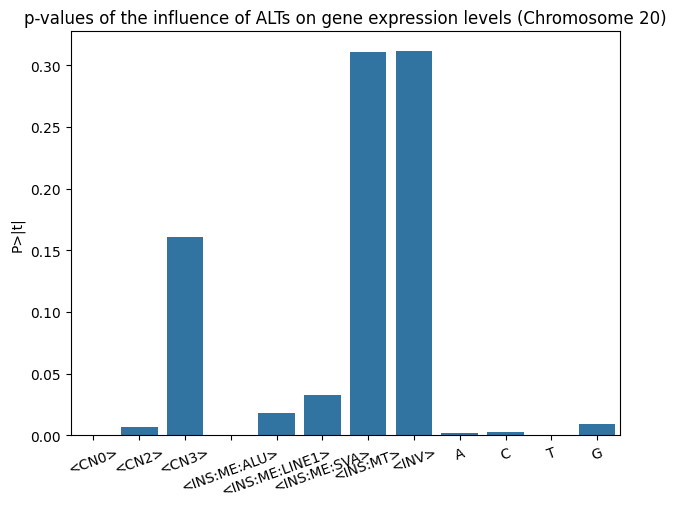

In [69]:
plt.title("p-values of the influence of ALTs on gene expression levels (Chromosome 20)")
sns.barplot(pd.concat([p_values1, p_values2, p_values3, p_values4], axis=0))
plt.tight_layout()
plt.xticks(rotation=20)
plt.show()

In [75]:
vcfRnaMerged.to_csv("mergedData.csv")